In [10]:
import ee
import geemap
ee.Initialize()

In [11]:
import requests
import pandas as pd
import json
import time

In [12]:
GEOCODE = '2919553'
Escala = 500;
url = f'http://servicodados.ibge.gov.br/api/v3/malhas/municipios/{GEOCODE}?formato=application/vnd.geo+json'
response = requests.get(url)
geo = response.json();
ee_object = geemap.geojson_to_ee(geo)
geometry = ee_object.geometry()

In [13]:
response

<Response [200]>

In [14]:
Map = geemap.Map(center=[-11.77,-45.76], zoom=8)

Map.addLayer(geometry, {}, "Geometria")

Map.addLayerControl() # This line is not needed for ipyleaflet-based Map.

Map


Map(center=[-11.77, -45.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(child…

In [15]:
#Se precisar especificar a geometria manualmente no mapa

#Map.draw_features
#roi = ee.FeatureCollection(Map.draw_features)
#geometry = roi.geometry()
#Map

In [16]:

def clusterization(image):

          
    # Load a pre-computed Landsat composite for input.
    input = image.clip(geometry).select("EVI");
  
    #Make the training dataset.
    training = input.sample(**{
    'region': geometry,
    'scale': Escala,
    'numPixels': 5000
    });

    #Instantiate the clusterer and train it.
    clusterer = ee.Clusterer.wekaKMeans(5).train(training)
    #Cluster the input using the trained clusterer.
    result = input.cluster(clusterer)
 
    #Combine the mean and standard deviation reducers.
    reducers = ee.Reducer.mean()

    #Inicialização Lista de EVI dos clustes
    lista = ee.List([])

    #Iteração sobre os 5 Clusters para calcular a estatística de cada região
    for i in range(5):

        #Cálculo da geometria
        geom = result.select("cluster").eq(i).selfMask().reduceToVectors(**{
        'scale':Escala,
        });



        #Reducer para cálculo do EVI médio de cada cluster
        stats = image.reduceRegion(**{
        'reducer': reducers,
        'geometry':geom.geometry(),
        'scale':Escala,
        'bestEffort':True,
        'maxPixels':10000000000,
        });

        #Armarzena o EVI médio de cada clúster em uma lista
        lista = lista.add(stats.get("EVI"));


    #Cópia da Lista para ordenar os 2 maiores EVIs
    lista2 = lista;


    #Ordenar a lista para pegar os 2 maiores valores de EVI médio nos clusters
    #Agora nossos clustests de interesse estão nas posições 3 e 4 da lista 2
    lista2 = lista2.sort()

    #Pegar as chaves dos clusteres de interesse na lista original
    chaves1 = lista.indexOf(lista2.get(3))
    chaves2 = lista.indexOf(lista2.get(4))


    #Cálculo da Geometria final

    geom1 = result.select("cluster").eq(chaves1).selfMask().reduceToVectors(**{
    'scale':Escala,
    });

    geom2 = result.select("cluster").eq(chaves2).selfMask().reduceToVectors(**{
    'scale':Escala,
    });

    #Geom é a feature collection de nossos clusters de interesse
    geom = geom1.merge(geom2);



    stats = image.reduceRegion(**{
    'reducer': reducers,
    'geometry':geom.geometry(),
    'scale':Escala,
    'bestEffort':True,
    'maxPixels':10000000000,
    });


    return image.set('EVI_Cluster', stats.get("EVI"))
    



In [17]:
import requests
import pandas as pd
import json
import time
#import os

#out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')


stats = list();

In [18]:
#Dividir o processamento das imagens de acordo com o ano para não sobrecarregar o sistema
ano = list(range(2000, 2022))

#string_ints = [str(int) for int in ano]
#stats = list();
    
for i in (ano):
    
    print ("Safra",i-1,"/",i)
    #Filtrar a territorialidade 
    #4 principais meses de safra
    #filter start and end date   
    mcollection = ee.ImageCollection('MODIS/006/MOD13Q1').filterBounds(geometry).filterDate( str(i-1) + '-11-01', str(i-1) +'-12-31').filter(ee.Filter.calendarRange(11, 12,'month')).map(clusterization)
    mcollection2 = ee.ImageCollection('MODIS/006/MOD13Q1').filterBounds(geometry).filterDate( str(i) + '-01-01', str(i) +'-02-28').filter(ee.Filter.calendarRange(1, 2,'month')).map(clusterization)    
    mcollection = mcollection.merge(mcollection2)
    
    #Pegar a propriedade que nos interessa em cada imagem - o EVI_Cluster Calculado 
    a = mcollection.aggregate_array('EVI_Cluster')
    
    
    #10s de soneca pra o GEE não derrubar as requests
    time.sleep(10)
    # Fazer a informação passar do servidor do google para o jupyter
    x = a.getInfo()
    #Salvar cada ano
    stats.append(x)    
    

Safra 1999 / 2000
Safra 2000 / 2001
Safra 2001 / 2002
Safra 2002 / 2003
Safra 2003 / 2004
Safra 2004 / 2005
Safra 2005 / 2006
Safra 2006 / 2007
Safra 2007 / 2008
Safra 2008 / 2009
Safra 2009 / 2010
Safra 2010 / 2011
Safra 2011 / 2012
Safra 2012 / 2013
Safra 2013 / 2014
Safra 2014 / 2015
Safra 2015 / 2016
Safra 2016 / 2017
Safra 2017 / 2018
Safra 2018 / 2019
Safra 2019 / 2020
Safra 2020 / 2021


In [19]:
stats

[[6774.910844014351],
 [3743.8195084485405,
  3689.723945688118,
  4916.1109458655565,
  5184.951148377689,
  5975.0345094998065,
  7042.510548590921,
  7413.061663323034],
 [4140.2019935502785,
  4508.608575902744,
  4232.235294117647,
  5356.0817541954275,
  6314.484995956278,
  7671.097008219969,
  7827.4065158444655,
  6667.835563228313],
 [3689.304873710423,
  3679.1419730615216,
  3644.2030273818023,
  4580.5083708950415,
  6381.313966480447,
  7057.3143722608,
  7094.065011517789,
  6863.983986339413],
 [4462.7828069032885,
  3911.849931787176,
  4636.810239117106,
  6329.482082695253,
  6618.79387924307,
  7200.818502249152,
  7680.493469497888,
  7408.045851411386],
 [3621.835716370003,
  4036.1166854565954,
  5919.348397064504,
  6283.683448275862,
  6780.495334550698,
  7787.479180093518,
  7593.206387280845],
 [3379.3160550458715,
  4051.6871426749203,
  4443.466740705422,
  5299.935823429541,
  6243.946742041059,
  6253.745026525199,
  7492.088650268812,
  7060.1961382215]

In [20]:
df = pd.DataFrame({'lin':stats})

In [21]:
#Separate comma
#df = df.apply(lambda x:pd.Series(x))

In [22]:
df = pd.DataFrame(stats, columns = ['EVI1', 'EVI2','EVI3','EVI4','EVI5','EVI6','EVI7','EVI8'])

In [23]:
df

,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8
0,6774.910844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3743.819508,3689.723946,4916.110946,5184.951148,5975.034509,7042.510549,7413.061663,NaN
2,4140.201994,4508.608576,4232.235294,5356.081754,6314.484996,7671.097008,7827.406516,6667.835563
3,3689.304874,3679.141973,3644.203027,4580.508371,6381.313966,7057.314372,7094.065012,6863.983986
4,4462.782807,3911.849932,4636.810239,6329.482083,6618.793879,7200.818502,7680.493469,7408.045851
5,3621.835716,4036.116685,5919.348397,6283.683448,6780.495335,7787.479180,7593.206387,NaN
6,3379.316055,4051.687143,4443.466741,5299.935823,6243.946742,6253.745027,7492.088650,7060.196138
7,4664.486888,4944.105315,4965.875565,5791.124082,6950.296461,7595.491283,7650.751435,7767.778647
8,3303.361694,3346.551138,3723.748734,4591.091949,4502.707187,6907.502956,7639.509773,7954.397711
9,3472.597485,4271.390331,4439.813106,6317.348858,7271.465540,8099.932696,8108.413747,NaN


In [24]:
#Reshape da 1a linha - Imagens do MODIS a partir de Mar/2000
#new_order =  ['EVI6', 'EVI7', 'EVI8','EVI1','EVI2','EVI3','EVI4','EVI5'] # specify new order of the third row
#i = 0 # specify row number
#df.loc[0] = df.loc[0, new_order].values

In [25]:
#Corrigir os Nans
#Features dos EVIS pronta
#Vale a pena talvez pegar os n maiores valores para tentar reduzir o efeito de anos com safra atrasada
df.fillna(0)


,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8
0,6774.910844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3743.819508,3689.723946,4916.110946,5184.951148,5975.034509,7042.510549,7413.061663,0.000000
2,4140.201994,4508.608576,4232.235294,5356.081754,6314.484996,7671.097008,7827.406516,6667.835563
3,3689.304874,3679.141973,3644.203027,4580.508371,6381.313966,7057.314372,7094.065012,6863.983986
4,4462.782807,3911.849932,4636.810239,6329.482083,6618.793879,7200.818502,7680.493469,7408.045851
5,3621.835716,4036.116685,5919.348397,6283.683448,6780.495335,7787.479180,7593.206387,0.000000
6,3379.316055,4051.687143,4443.466741,5299.935823,6243.946742,6253.745027,7492.088650,7060.196138
7,4664.486888,4944.105315,4965.875565,5791.124082,6950.296461,7595.491283,7650.751435,7767.778647
8,3303.361694,3346.551138,3723.748734,4591.091949,4502.707187,6907.502956,7639.509773,7954.397711
9,3472.597485,4271.390331,4439.813106,6317.348858,7271.465540,8099.932696,8108.413747,0.000000


In [26]:
url = f'https://apiprevmet3.inmet.gov.br/estacao/proxima/{GEOCODE}'
response = requests.get(url).json()
response

{'estacao': {'UF': 'TO',
  'CODIGO': 'A038',
  'LONGITUDE': '-46.84722221',
  'REGIAO': 'N',
  'DISTANCIA_EM_KM': '115',
  'NOME': 'DIANOPOLIS',
  'LATITUDE': '-11.59444444',
  'GEOCODE': '1707009'},
 'dados': {'DC_NOME': 'DIANOPOLIS',
  'PRE_INS': None,
  'TEM_SEN': None,
  'VL_LATITUDE': '-11.59444444',
  'PRE_MAX': None,
  'UF': 'TO',
  'RAD_GLO': None,
  'PTO_INS': None,
  'TEM_MIN': None,
  'VL_LONGITUDE': '-46.84722221',
  'UMD_MIN': None,
  'PTO_MAX': None,
  'VEN_DIR': None,
  'DT_MEDICAO': '2021-08-11',
  'CHUVA': None,
  'PRE_MIN': None,
  'UMD_MAX': None,
  'VEN_VEL': None,
  'PTO_MIN': None,
  'TEM_MAX': None,
  'VEN_RAJ': None,
  'TEM_INS': None,
  'UMD_INS': None,
  'CD_ESTACAO': 'A038',
  'HR_MEDICAO': '1700'}}

In [27]:
estacao = response['dados']['CD_ESTACAO']

In [28]:
new_url = f'https://apitempo.inmet.gov.br/estacao/diaria/1999-11-01/2021-04-30/{estacao}'
json_response = requests.get(new_url).json()
dados_estacao = pd.DataFrame(json_response)
dados_estacao

,UMID_MED,DT_MEDICAO,DC_NOME,UMID_MIN,TEMP_MED,CHUVA,VL_LATITUDE,TEMP_MIN,TEMP_MAX,UF,VEL_VENTO_MED,CD_ESTACAO,VL_LONGITUDE
0,None,1999-11-01,DIANOPOLIS,None,None,None,-11.59444444,None,None,TO,None,A038,-46.84722221
1,None,1999-11-02,DIANOPOLIS,None,None,None,-11.59444444,None,None,TO,None,A038,-46.84722221
2,None,1999-11-03,DIANOPOLIS,None,None,None,-11.59444444,None,None,TO,None,A038,-46.84722221
3,None,1999-11-04,DIANOPOLIS,None,None,None,-11.59444444,None,None,TO,None,A038,-46.84722221
4,None,1999-11-05,DIANOPOLIS,None,None,None,-11.59444444,None,None,TO,None,A038,-46.84722221
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7847,86.9,2021-04-26,DIANOPOLIS,57,22.9,None,-11.59444444,18.6,30.3,TO,0.8,A038,-46.84722221
7848,88.5,2021-04-27,DIANOPOLIS,58,22.6,None,-11.59444444,19.3,28.9,TO,1.7,A038,-46.84722221
7849,83.8,2021-04-28,DIANOPOLIS,69,23.7,None,-11.59444444,21.4,28.1,TO,0.4,A038,-46.84722221
7850,83.3,2021-04-29,DIANOPOLIS,52,23.9,None,-11.59444444,20,31.6,TO,1.4,A038,-46.84722221


In [29]:
dados_estacao['CHUVA'] = dados_estacao['CHUVA'].astype(float)
dados_estacao['DT_MEDICAO'] = pd.to_datetime(dados_estacao['DT_MEDICAO'])
dados_estacao['ANO'] = dados_estacao['DT_MEDICAO'].dt.year
dados_estacao['MES'] = dados_estacao['DT_MEDICAO'].dt.month
dados_estacao

,UMID_MED,DT_MEDICAO,DC_NOME,UMID_MIN,TEMP_MED,CHUVA,VL_LATITUDE,TEMP_MIN,TEMP_MAX,UF,VEL_VENTO_MED,CD_ESTACAO,VL_LONGITUDE,ANO,MES
0,None,1999-11-01,DIANOPOLIS,None,None,NaN,-11.59444444,None,None,TO,None,A038,-46.84722221,1999,11
1,None,1999-11-02,DIANOPOLIS,None,None,NaN,-11.59444444,None,None,TO,None,A038,-46.84722221,1999,11
2,None,1999-11-03,DIANOPOLIS,None,None,NaN,-11.59444444,None,None,TO,None,A038,-46.84722221,1999,11
3,None,1999-11-04,DIANOPOLIS,None,None,NaN,-11.59444444,None,None,TO,None,A038,-46.84722221,1999,11
4,None,1999-11-05,DIANOPOLIS,None,None,NaN,-11.59444444,None,None,TO,None,A038,-46.84722221,1999,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7847,86.9,2021-04-26,DIANOPOLIS,57,22.9,NaN,-11.59444444,18.6,30.3,TO,0.8,A038,-46.84722221,2021,4
7848,88.5,2021-04-27,DIANOPOLIS,58,22.6,NaN,-11.59444444,19.3,28.9,TO,1.7,A038,-46.84722221,2021,4
7849,83.8,2021-04-28,DIANOPOLIS,69,23.7,NaN,-11.59444444,21.4,28.1,TO,0.4,A038,-46.84722221,2021,4
7850,83.3,2021-04-29,DIANOPOLIS,52,23.9,NaN,-11.59444444,20,31.6,TO,1.4,A038,-46.84722221,2021,4


In [30]:
b  = dados_estacao.groupby(['ANO', 'MES'])['CHUVA'].sum().fillna(0)

In [31]:
mask = (dados_estacao['MES'] <= 4) | (dados_estacao['MES'] >= 11)  
b = dados_estacao.loc[mask].groupby(['ANO', 'MES'])['CHUVA'].sum().fillna(0)

In [32]:
chuva = b.values.reshape(22,6)
df2 = pd.DataFrame(chuva, columns = ['C_NOV', 'C_DEZ','C_JAN','C_FEV','C_MAR','C_ABR'])
df2

,C_NOV,C_DEZ,C_JAN,C_FEV,C_MAR,C_ABR
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0
9,261.4,320.8,367.4,231.4,273.8,337.4


In [76]:
concat_data = pd.concat([df,df2],axis=1).fillna(0)

In [80]:
concat_data

,index,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8,C_NOV,C_DEZ,C_JAN,C_FEV,C_MAR,C_ABR
0,0,6774.910844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,3743.819508,3689.723946,4916.110946,5184.951148,5975.034509,7042.510549,7413.061663,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,4140.201994,4508.608576,4232.235294,5356.081754,6314.484996,7671.097008,7827.406516,6667.835563,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3689.304874,3679.141973,3644.203027,4580.508371,6381.313966,7057.314372,7094.065012,6863.983986,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4462.782807,3911.849932,4636.810239,6329.482083,6618.793879,7200.818502,7680.493469,7408.045851,0.0,0.0,0.0,0.0,0.0,0.0
5,5,3621.835716,4036.116685,5919.348397,6283.683448,6780.495335,7787.479180,7593.206387,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,6,3379.316055,4051.687143,4443.466741,5299.935823,6243.946742,6253.745027,7492.088650,7060.196138,0.0,0.0,0.0,0.0,0.0,0.0
7,7,4664.486888,4944.105315,4965.875565,5791.124082,6950.296461,7595.491283,7650.751435,7767.778647,0.0,0.0,0.0,0.0,0.0,0.0
8,8,3303.361694,3346.551138,3723.748734,4591.091949,4502.707187,6907.502956,7639.509773,7954.397711,0.0,0.0,0.0,0.0,0.0,0.0
9,9,3472.597485,4271.390331,4439.813106,6317.348858,7271.465540,8099.932696,8108.413747,0.000000,261.4,320.8,367.4,231.4,273.8,337.4


In [75]:
# Api PAM SIDRA/ https://apisidra.ibge.gov.br/values/t/5457/n6/2919553/v/112/p/last%2020/c782/40124

In [36]:
url3 = f'https://apisidra.ibge.gov.br/values/t/5457/n6/{GEOCODE}/v/112/p/last%2020/c782/40124'
json_response = requests.get(url3).json()
produtividade = pd.DataFrame(json_response)
Y = produtividade['V'].iloc[1:].values.ravel()
Y

array(['...', '2040', '1829', '1829', '2880', '2759', '2280', '2700',
       '3036', '2550', '3060', '3360', '3480', '2280', '2580', '3240',
       '2100', '3413', '4159', '3818'], dtype=object)

In [160]:
#Produtividade de Soja por ano - PAM/SIDRA
df3 = pd.DataFrame(Y)
df3?

In [38]:
import sklearn
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [39]:
#Normalizar o Xtrain
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#min_max_scaler = preprocessing.MinMaxScaler()
#X_train_minmax = min_max_scaler.fit_transform(Xtrain)

#Modelagem com os 3 maiores EVIS
df = df.fillna(0)
B = df.apply(lambda x: np.sort(x), axis=1, raw=True)#df = df.assign(max_value=df.values.max(1))
B
#df
#c = ['1st Max','2nd Max','3rd Max']


#xf = (df.apply(lambda x: pd.Series(x.nlargest(3)), axis=1))
#xf.dropna(axis=0)
#xf = xf.fillna(0)
#xf

,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6774.910844
1,0.000000,3689.723946,3743.819508,4916.110946,5184.951148,5975.034509,7042.510549,7413.061663
2,4140.201994,4232.235294,4508.608576,5356.081754,6314.484996,6667.835563,7671.097008,7827.406516
3,3644.203027,3679.141973,3689.304874,4580.508371,6381.313966,6863.983986,7057.314372,7094.065012
4,3911.849932,4462.782807,4636.810239,6329.482083,6618.793879,7200.818502,7408.045851,7680.493469
5,0.000000,3621.835716,4036.116685,5919.348397,6283.683448,6780.495335,7593.206387,7787.479180
6,3379.316055,4051.687143,4443.466741,5299.935823,6243.946742,6253.745027,7060.196138,7492.088650
7,4664.486888,4944.105315,4965.875565,5791.124082,6950.296461,7595.491283,7650.751435,7767.778647
8,3303.361694,3346.551138,3723.748734,4502.707187,4591.091949,6907.502956,7639.509773,7954.397711
9,0.000000,3472.597485,4271.390331,4439.813106,6317.348858,7271.465540,8099.932696,8108.413747


In [40]:
#X_treino com dados do passado e X_Test com dados do futuro
#Selecionei só 3 medidas do EVI para não ficar muita feature
Xtrain = B.iloc[1:19,4:9].fillna(0)
Xtest =  B.iloc[19:22,4:9].fillna(0)
Ytrain = Y[1:19]
Ytest = Y[19:20]

In [41]:
# Regressão Linear Simples
LR = LinearRegression()
# fitting the training data
LR.fit(Xtrain,Ytrain)
Y_LR =  LR.predict(Xtrain)

In [42]:
#Regressão Polinomial SVR

svr_poly = SVR(kernel='poly', C=1e3, degree=3)
Y_Poly = svr_poly.fit(Xtrain, Ytrain).predict(Xtrain)

In [43]:
#Regressão Ridge
reg = linear_model.Ridge(alpha=.5)
Y_Ridge = reg.fit(Xtrain, Ytrain).predict(Xtrain)

In [44]:
#Regressão Bayseana
regB = linear_model.BayesianRidge()
Y_Bay = regB.fit(Xtrain, Ytrain).predict(Xtrain)

In [45]:
# predicting the accuracy score
score=r2_score(Ytrain,Y_LR)
print("r2 Linear ",score)
print("mean_sqrd_error Linear ==",mean_squared_error(Ytrain,Y_LR))
score=r2_score(Ytrain,Y_Poly)
print("r2 Poly ",score)
print("mean_sqrd_error Polinomial ==",mean_squared_error(Ytrain,Y_Poly))
score=r2_score(Ytrain,Y_Ridge)
print("r2 Ridge ",score)
print("mean_sqrd_error Ridge ==",mean_squared_error(Ytrain,Y_Ridge))
score=r2_score(Ytrain,Y_Bay)
print("r2 Bayseano ",score)
print("mean_sqrd_error Bayseano ==",mean_squared_error(Ytrain,Y_Bay))


r2 Linear  0.6230324226160858
mean_sqrd_error Linear == 144520.91881246635
r2 Poly  0.7398231334877832
mean_sqrd_error Polinomial == 99745.97832269296
r2 Ridge  0.6230324226152258
mean_sqrd_error Ridge == 144520.91881279604
r2 Bayseano  0.4726263985886926
mean_sqrd_error Bayseano == 202183.21682286361


In [46]:
print("Produtividade em 2019:",Ytest)
print("Produtividade Reg Linear:",LR.predict(Xtest))
print("Produtividade Reg Polinomial:",svr_poly.predict(Xtest))
print("Produtividade Reg Ridge:",reg.predict(Xtest))
print("Produtividade Reg Bayeseana:",regB.predict(Xtest))

Produtividade em 2019: ['3818']
Produtividade Reg Linear: [3733.68843431 3592.0363799  2856.90384317]
Produtividade Reg Polinomial: [3984.05731213 3567.78584093 3107.56987905]
Produtividade Reg Ridge: [3733.68684604 3592.0358314  2856.90498026]
Produtividade Reg Bayeseana: [3074.9696051  3304.25482578 3229.78801305]


In [47]:
#Tentativa de Plotar 1 dimensão de feature x Y
#import matplotlib.pyplot as plt
#import numpy as np

#plt.plot(x_plot,y_plot, 'o')
#plt.plot(x_plot,y_poly)
#plt.plot(x_plot,y_prediction)
#plt.show()
Xtrain

,EVI5,EVI6,EVI7,EVI8
1,5184.951148,5975.034509,7042.510549,7413.061663
2,6314.484996,6667.835563,7671.097008,7827.406516
3,6381.313966,6863.983986,7057.314372,7094.065012
4,6618.793879,7200.818502,7408.045851,7680.493469
5,6283.683448,6780.495335,7593.206387,7787.479180
6,6243.946742,6253.745027,7060.196138,7492.088650
7,6950.296461,7595.491283,7650.751435,7767.778647
8,4591.091949,6907.502956,7639.509773,7954.397711
9,6317.348858,7271.465540,8099.932696,8108.413747
10,6998.876977,7560.255345,7882.624113,8144.973895


In [48]:
import statsmodels.api as sm

In [81]:
concat_data = concat_data.reset_index()
concat_data

,level_0,index,EVI1,EVI2,EVI3,EVI4,EVI5,EVI6,EVI7,EVI8,C_NOV,C_DEZ,C_JAN,C_FEV,C_MAR,C_ABR
0,0,0,6774.910844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,3743.819508,3689.723946,4916.110946,5184.951148,5975.034509,7042.510549,7413.061663,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,4140.201994,4508.608576,4232.235294,5356.081754,6314.484996,7671.097008,7827.406516,6667.835563,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3,3689.304874,3679.141973,3644.203027,4580.508371,6381.313966,7057.314372,7094.065012,6863.983986,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,4462.782807,3911.849932,4636.810239,6329.482083,6618.793879,7200.818502,7680.493469,7408.045851,0.0,0.0,0.0,0.0,0.0,0.0
5,5,5,3621.835716,4036.116685,5919.348397,6283.683448,6780.495335,7787.479180,7593.206387,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,6,6,3379.316055,4051.687143,4443.466741,5299.935823,6243.946742,6253.745027,7492.088650,7060.196138,0.0,0.0,0.0,0.0,0.0,0.0
7,7,7,4664.486888,4944.105315,4965.875565,5791.124082,6950.296461,7595.491283,7650.751435,7767.778647,0.0,0.0,0.0,0.0,0.0,0.0
8,8,8,3303.361694,3346.551138,3723.748734,4591.091949,4502.707187,6907.502956,7639.509773,7954.397711,0.0,0.0,0.0,0.0,0.0,0.0
9,9,9,3472.597485,4271.390331,4439.813106,6317.348858,7271.465540,8099.932696,8108.413747,0.000000,261.4,320.8,367.4,231.4,273.8,337.4


In [151]:
sli1 = B.iloc[1:20,6:9].fillna(0)
endog_s1i1 = df3[1:20]
arimax = sm.tsa.ARIMA(endog=endog_s1i1.astype(float),exog=sli1,order=(0,0,0)).fit()


In [152]:
fcst = arimax.predict(start=0, end=19, dynamic=True, exog=sli1)
fcst

1     2426.937050
2     2573.050871
3     1801.274585
4     2562.581254
5     2576.790480
6     2559.965360
7     2479.881560
8     2848.561746
9     2669.540986
10    2963.098590
11    2900.719055
12    2808.843758
13    2895.401887
14    2383.270383
15    3297.616140
16    3439.859004
17    3192.081495
18    3676.690623
19    3336.834773
20    2426.937050
dtype: float64

In [122]:
Ytrain

array(['2040', '1829', '1829', '2880', '2759', '2280', '2700', '3036',
       '2550', '3060', '3360', '3480', '2280', '2580', '3240', '2100',
       '3413', '4159'], dtype=object)

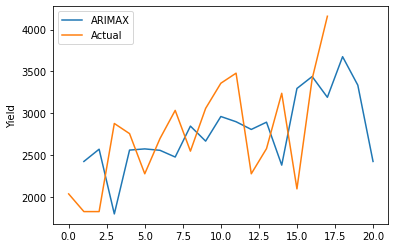

In [161]:
import matplotlib.pyplot as plt
%matplotlib inline

Y_r = pd.Series(Ytrain).astype(float)

fcst.plot()
Y_r.plot()
plt.legend(['ARIMAX', 'Actual'])
plt.ylabel('Yield');

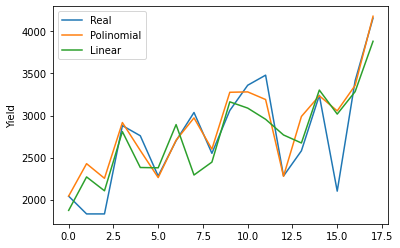

In [164]:
Y_r.plot()
pd.Series(Y_Poly).plot()
pd.Series(Y_LR).plot()
plt.legend(['Real','Polinomial', 'Linear'])
plt.ylabel('Yield');